# 1 Getting started with GraphX

## 1.1 Intro of GraphX

**GraphX is a component in Spark for graphs and graph-parallel computation**. At a high level, GraphX extends the Spark RDD by introducing a new Graph abstraction: **a directed multigraph with properties attached to each vertex and edge**. To support graph computation, GraphX exposes a set of fundamental operators (e.g., `subgraph, joinVertices, and aggregateMessages`) as well as an `optimized variant` of the [Pregel](https://spark.apache.org/docs/latest/graphx-programming-guide.html#pregel) API. In addition, GraphX includes a growing collection of graph algorithms and builders to simplify graph analytics tasks.

The official doc can be found [here](https://spark.apache.org/docs/latest/graphx-programming-guide.html#getting-started)


## 1.2 Installation
Although GraphX is a component of Spark (no need to install), but it uses a special data structure (**graphframes**) which is not included in Spark by default.
We need to import the lib `graphframes` which allows us to create dataframe for graphe.

The official doc of the data structure can be found [here](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

The jar file can be downloaded [here](http://spark-packages.org/package/graphframes/graphframes)

For scala api, it's quite simple, you can download the jar file, add the jar file to the context, Or ask the spark session to download it automatically by using below
`.config('spark.jars.packages','graphframes:graphframes:0.8.2-spark3.2-s_2.12')`.

For python api, you need to do the above steps, and you need to install a python wrapper in your virtual env.

```shell
pip install graphframes
```

> If you visit the pypi page of this package, it's a little outdated. But it's only a wrapper, for now I don't encounter any compatibility issues.

## 2 A simple example

In below example, we will create two classical dataframes:
1. store all vertices (nodes) of the graphe
2. store all edges (relations between nodes) of the graphe

Then we will create a graph frame by using the two dataframes.

In [2]:
from pyspark.sql import SparkSession
from graphframes import *
import os

In [3]:
local=True
if local:
    spark = SparkSession.builder\
        .master("local[4]")\
        .appName("RepartitionAndCoalesce")\
        .config("spark.executor.memory", "4g")\
        .config('spark.jars.packages','graphframes:graphframes:0.8.2-spark3.2-s_2.12') \
        .getOrCreate()
else:
    spark = SparkSession.builder\
        .master("k8s://https://kubernetes.default.svc:443")\
        .appName("RepartitionAndCoalesce")\
        .config("spark.kubernetes.container.image", "inseefrlab/jupyter-datascience:master")\
        .config("spark.kubernetes.authenticate.driver.serviceAccountName", os.environ['KUBERNETES_SERVICE_ACCOUNT'])\
        .config('spark.jars.packages','graphframes:graphframes:0.8.2-spark3.2-s_2.12') \
        .config("spark.executor.instances", "4")\
        .config("spark.executor.memory","2g")\
        .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])\
        .getOrCreate()

# make the large dataframe show pretty
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

23/09/27 17:01:18 WARN Utils: Your hostname, pengfei-Virtual-Machine resolves to a loopback address: 127.0.1.1; using 10.50.2.80 instead (on interface eth0)
23/09/27 17:01:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/pengfei/opt/spark-3.3.0/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/pengfei/.ivy2/cache
The jars for the packages stored in: /home/pengfei/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-721567a5-7fa4-4f83-a31b-ffd1a21fa62a;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 455ms :: artifacts dl 38ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	------------------------------

23/09/27 17:01:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
vertices = spark.createDataFrame([('1', 'Carter', 'Derrick', 50),
                                  ('2', 'May', 'Derrick', 26),
                                 ('3', 'Mills', 'Jeff', 80),
                                  ('4', 'Hood', 'Robert', 65),
                                  ('5', 'Banks', 'Mike', 93),
                                 ('98', 'Berg', 'Tim', 28),
                                 ('99', 'Page', 'Allan', 16)],
                                 ['id', 'name', 'firstname', 'age'])

edges = spark.createDataFrame([('1', '2', 'friend'),
                               ('2', '1', 'friend'),
                              ('3', '1', 'friend'),
                              ('1', '3', 'friend'),
                               ('2', '3', 'follows'),
                               ('3', '4', 'friend'),
                               ('4', '3', 'friend'),
                               ('5', '3', 'friend'),
                               ('3', '5', 'friend'),
                               ('4', '5', 'follows'),
                              ('98', '99', 'friend'),
                              ('99', '98', 'friend')],
                              ['src', 'dst', 'type'])

In [5]:
g = GraphFrame(vertices, edges)

/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [6]:
# show the vertices (nodes)
g.vertices.show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  2|   May|  Derrick| 26|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
| 98|  Berg|      Tim| 28|
| 99|  Page|    Allan| 16|
+---+------+---------+---+


In [7]:
# show the edges (relations between nodes)
g.edges.show()

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+


In [8]:
## Check the number of edges of each vertex
g.degrees.show()

/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+------+
| id|degree|
+---+------+
|  3|     7|
|  1|     4|
|  2|     3|
|  4|     3|
|  5|     3|
| 98|     2|
| 99|     2|
+---+------+


The GraphFrame we just created is a **directed graph**, and can be visualized as follows:
![graphx_graph_exp1.webp](../../../../images/graphx_graph_exp1.webp)





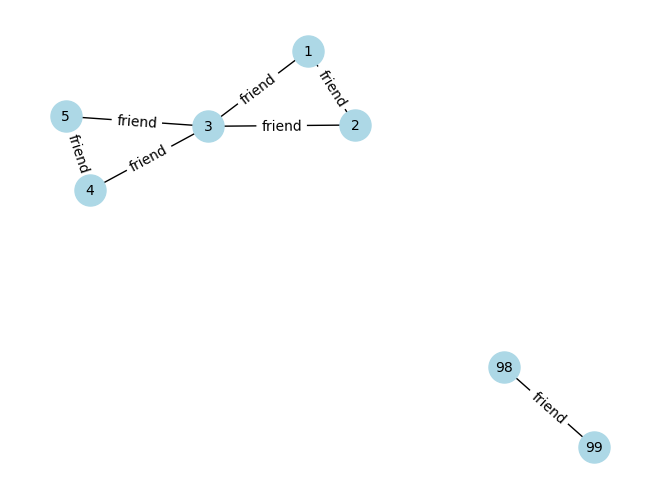

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

nx_graph = nx.Graph()
for edge in g.edges.collect():
    nx_graph.add_edge(edge["src"], edge["dst"])

# Define layout
pos = nx.spring_layout(nx_graph, seed=42)

# Draw nodes and edges
nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
labels = {edge: "friend" for edge, data in nx_graph.edges.items()}
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=labels)

plt.show()

In [10]:
for edge, data in nx_graph.edges.items():
    print(edge)
    print(data)

('1', '2')
{}
('1', '3')
{}
('2', '3')
{}
('3', '4')
{}
('3', '5')
{}
('4', '5')
{}
('98', '99')
{}


## 2. Filtering the graph

A GraphFrame itself can’t be filtered, but DataFrames deducted from a Graph can. Consequently, the filter-function (or any other function) can be used just as you would use it with DataFrames. The only trap-hole might be the correct use of quotation marks: the whole condition should be quoted. The examples below should clarify this.

In [9]:
# filter all the nodes which has age > 30
filteredNode= g.vertices.filter("age > 30")
filteredNode.show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
+---+------+---------+---+


In [10]:
# get all the nodes which has at least 2 relations
filteredByDegree=g.inDegrees.filter("inDegree >= 2").sort("inDegree", ascending=False)
filteredByDegree.show()

/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+--------+
| id|inDegree|
+---+--------+
|  3|       4|
|  1|       2|
|  5|       2|
+---+--------+


In [11]:
# get all relation which is friend
filteredEdge=g.edges.filter('type == "friend"')
filteredEdge.show()

+---+---+------+
|src|dst|  type|
+---+---+------+
|  1|  2|friend|
|  2|  1|friend|
|  3|  1|friend|
|  1|  3|friend|
|  3|  4|friend|
|  4|  3|friend|
|  5|  3|friend|
|  3|  5|friend|
| 98| 99|friend|
| 99| 98|friend|
+---+---+------+


In [12]:
# get all relation which is follows
filteredEdge=g.edges.filter('type == "follows"')
filteredEdge.show()

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  2|  3|follows|
|  4|  5|follows|
+---+---+-------+


## 3. Connected components

A connected component of a graph is a subgraph in which any two vertices are connected to each other by one or more edges, and which is connected to no additional vertices in the supergraph. In the (undirected) example below there are three connected components. Connected components detection can be interesting for clustering, but also to make your computations more efficient.

> Practically, GraphFrames requires you to set a directory where it can save checkpoints. Create such a folder in your working directory and drop the following line (where graphframes_cps is your new folder) in Jupyter to set the checkpoint directory.

Then, the connected components can easily be computed with the connectedComponents-function.

In [12]:
spark.sparkContext.setCheckpointDir("/tmp/graphframes_cps")

In [13]:
# get the connected components
g.connectedComponents().show()

/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+------+---------+---+------------+
| id|  name|firstname|age|   component|
+---+------+---------+---+------------+
|  1|Carter|  Derrick| 50|154618822656|
|  2|   May|  Derrick| 26|154618822656|
|  3| Mills|     Jeff| 80|154618822656|
|  4|  Hood|   Robert| 65|154618822656|
|  5| Banks|     Mike| 93|154618822656|
| 98|  Berg|      Tim| 28|317827579904|
| 99|  Page|    Allan| 16|317827579904|
+---+------+---------+---+------------+


Our mini-graph has two connected components, which are described for each vertex in the **component column**.

NameError: name 'g' is not defined

## 4. Motif finding

Finding motifs helps to execute queries to discover structural patterns in graphs. Network motifs are patterns that occur repeatedly in the graph and represent the relationships between the vertices. GraphFrames motif finding uses a declarative Domain Specific Language (DSL) for expressing structural queries.

The query can be invoked by using the find-function, where the motif (in quotation marks) is expressed as the first parameter of the function.

The following example will search for pairs of vertices a,b connected by edge e and pairs of vertices b,c connected by edge e2. It will return a DataFrame of all such structures in the graph, with columns for each of the named elements (vertices or edges) in the motif.

In [14]:
g.find("(a)-[e]->(b); (b)-[e2]->(a)").show()

+--------------------+----------------+--------------------+----------------+
|                   a|               e|                   b|              e2|
+--------------------+----------------+--------------------+----------------+
|{2, May, Derrick,...|  {2, 1, friend}|{1, Carter, Derri...|  {1, 2, friend}|
|{3, Mills, Jeff, 80}|  {3, 1, friend}|{1, Carter, Derri...|  {1, 3, friend}|
|{1, Carter, Derri...|  {1, 2, friend}|{2, May, Derrick,...|  {2, 1, friend}|
|{1, Carter, Derri...|  {1, 3, friend}|{3, Mills, Jeff, 80}|  {3, 1, friend}|
|{4, Hood, Robert,...|  {4, 3, friend}|{3, Mills, Jeff, 80}|  {3, 4, friend}|
|{5, Banks, Mike, 93}|  {5, 3, friend}|{3, Mills, Jeff, 80}|  {3, 5, friend}|
|{3, Mills, Jeff, 80}|  {3, 4, friend}|{4, Hood, Robert,...|  {4, 3, friend}|
|{3, Mills, Jeff, 80}|  {3, 5, friend}|{5, Banks, Mike, 93}|  {5, 3, friend}|
|{99, Page, Allan,...|{99, 98, friend}| {98, Berg, Tim, 28}|{98, 99, friend}|
| {98, Berg, Tim, 28}|{98, 99, friend}|{99, Page, Allan,...|{99,

If edges and/or vertices are anonymous, they won’t be displayed in the resulting DataFrame. Motifs can be joined by a semicolon and can be negated with a exclamation mark. More details about the Domain Specific Language can be found in the [documentation](https://graphframes.github.io/graphframes/docs/_site/user-guide.html).

As an example we can try to find the mutual friends for any pair of users a and c. In order to be a mutual friend b, b must be a friend with both a and c (and not just followed by c, for example).

In [16]:
mutualFriends = g.find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(b); (b)-[]->(a)").dropDuplicates()
mutualFriends.show()

/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+--------------------+--------------------+--------------------+
|                   a|                   b|                   c|
+--------------------+--------------------+--------------------+
|{4, Hood, Robert,...|{3, Mills, Jeff, 80}|{4, Hood, Robert,...|
|{3, Mills, Jeff, 80}|{1, Carter, Derri...|{2, May, Derrick,...|
|{4, Hood, Robert,...|{3, Mills, Jeff, 80}|{1, Carter, Derri...|
|{5, Banks, Mike, 93}|{3, Mills, Jeff, 80}|{1, Carter, Derri...|
|{3, Mills, Jeff, 80}|{1, Carter, Derri...|{3, Mills, Jeff, 80}|
|{5, Banks, Mike, 93}|{3, Mills, Jeff, 80}|{5, Banks, Mike, 93}|
|{5, Banks, Mike, 93}|{3, Mills, Jeff, 80}|{4, Hood, Robert,...|
|{1, Carter, Derri...|{2, May, Derrick,...|{1, Carter, Derri...|
|{1, Carter, Derri...|{3, Mills, Jeff, 80}|{4, Hood, Robert,...|
|{2, May, Derrick,...|{1, Carter, Derri...|{3, Mills, Jeff, 80}|
|{1, Carter, Derri...|{3, Mills, Jeff, 80}|{5, Banks, Mike, 93}|
|{1, Carter, Derri...|{3, Mills, Jeff, 80}|{1, Carter, Derri...|
|{99, Page, Allan,...| {9

In [18]:
# To query all the mutual friends between 2 and 3 we can filter the DataFrame.

mutualFriends.filter('a.id == 2 and c.id == 3').show(truncate=False)

+---------------------+------------------------+--------------------+
|a                    |b                       |c                   |
+---------------------+------------------------+--------------------+
|{2, May, Derrick, 26}|{1, Carter, Derrick, 50}|{3, Mills, Jeff, 80}|
+---------------------+------------------------+--------------------+


## 5. TriangleCount and PageRank

To finish up, we’ll discover two additional built-in algorithms. TriangleCount counts the number of triangles passing through each vertex in this graph. A triangle can be defined as a group of three vertices that is interrelated, i.e. a has an edge to b, b has an edge to c, and c has an edge to a. The example below shows a graph with two triangles.

![](../../../../images/graphx_graph_exp2.webp)

In the GraphFrames package you can count the number of triangles passing through each vertex by invoking the triangleCount-function. Note that our simple example has only two triangles in total. Triangles are used for various tasks for real‐life networks, including community discovery, link prediction, and spam filtering.

In [19]:
g.triangleCount().show()

/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-----+---+------+---------+---+
|count| id|  name|firstname|age|
+-----+---+------+---------+---+
|    1|  1|Carter|  Derrick| 50|
|    2|  3| Mills|     Jeff| 80|
|    1|  2|   May|  Derrick| 26|
|    1|  5| Banks|     Mike| 93|
|    1|  4|  Hood|   Robert| 65|
|    0| 98|  Berg|      Tim| 28|
|    0| 99|  Page|    Allan| 16|
+-----+---+------+---------+---+


The last function we discuss is PageRank. PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites.

The PageRank algorithm holds that an imaginary surfer who is randomly clicking on links will eventually stop clicking. The probability, at any step, that the person will continue is a damping factor. The damping factor can be be set by changing the resetProbability parameter. Other important parameters are the tolerance (tol) and the maximum number of iterations (maxIter).

In [20]:
pr = g.pageRank(resetProbability=0.15, tol=0.01)
## look at the pagerank score for every vertex
pr.vertices.show()
## look at the weight of every edge
pr.edges.show()

/home/pengfei/.cache/pypoetry/virtualenvs/sparkcommonfunc-jby-k8HJ-py3.8/lib/python3.8/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+---+------+---------+---+------------------+
| id|  name|firstname|age|          pagerank|
+---+------+---------+---+------------------+
|  3| Mills|     Jeff| 80| 1.853919642738813|
| 98|  Berg|      Tim| 28|1.0225331112091938|
| 99|  Page|    Allan| 16|1.0225331112091938|
|  5| Banks|     Mike| 93|0.9703579134677663|
|  1|Carter|  Derrick| 50|0.9055074972891308|
|  4|  Hood|   Robert| 65|0.6873519241384106|
|  2|   May|  Derrick| 26|0.5377967999474921|
+---+------+---------+---+------------------+


+---+---+-------+------------------+
|src|dst|   type|            weight|
+---+---+-------+------------------+
|  3|  5| friend|0.3333333333333333|
|  3|  1| friend|0.3333333333333333|
|  3|  4| friend|0.3333333333333333|
| 98| 99| friend|               1.0|
| 99| 98| friend|               1.0|
|  5|  3| friend|               1.0|
|  1|  3| friend|               0.5|
|  1|  2| friend|               0.5|
|  4|  3| friend|               0.5|
|  4|  5|follows|               0.5|
|  2|  3|follows|               0.5|
|  2|  1| friend|               0.5|
+---+---+-------+------------------+



## 6 Directed vs un directed edges

Undirected graphs have edges that do not have a direction. The edges indicate a two-way relationship, in that each edge can be traversed in both directions. If your DataFrame only consist of two-way directed edges, you may be interested in analyzing undirected edges. You can convert your graph by mapping a function over the edges DataFrame that deletes the row if src ≥ dst (or the other way around). In GraphX you could use to_undirected() to create a deep, undirected copy of the Graph, unfortunately GraphFrames does not support this functionality.

An easy example to work around this missing functionality can be found in the following code snippet. Please note that the ‘follows’ edge doesn’t really make sense in an undirected graph, since doesn’t represent a two-way relationship.

```python
copy = edges
from pyspark.sql.functions import udf
@udf("string")
def to_undir(src, dst):
    if src >= dst:
        return 'Delete'
    else :
        return 'Keep'
copy.withColumn('undir', to_undir(copy.src, copy.dst))\
.filter('undir == "Keep"').drop('undir').show()
## for efficiency, it's better to avoid udf functions where possible ## and use built-in pyspark.sql.functions instead.
```